In [1]:
# We load the data into a dataframe. I have downloaded the data my current folder and I load it from there
import pandas as pd
import os
base_path = os.getcwd()
file_name = "dftRoadSafetyData_Accidents_2018.csv"
path = os.path.join(base_path, file_name)
df_RS = pd.read_csv(path)

/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [2]:
####################     FIRST OBSERVATIONS     ####################

In [3]:
# The data comes with 32 columns, almost all of them in numeric format, but categorical data, 
# and without so many missing data (more of the 90% are non-null)
# There are three datetime columns that we can join together and see if there's any periodicity of the accidents along
# the year or the moment of the day. In fact the best option would be to take the data 
# from the years before provided by the same webpage but in the test description it was said 2018.
# I assume the idea is that it's the unique data I would have access in a real case. 
# This is clearly a bynary classification problem with labels "30  Did_Police_Officer_Attend_Scene_of_Accident"
# We can cluster the features in three main types: localization, time and kind of accident
df_RS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122635 entries, 0 to 122634
Data columns (total 32 columns):
 #   Column                                       Non-Null Count   Dtype  
---  ------                                       --------------   -----  
 0   Accident_Index                               122635 non-null  object 
 1   Location_Easting_OSGR                        122580 non-null  float64
 2   Location_Northing_OSGR                       122580 non-null  float64
 3   Longitude                                    122580 non-null  float64
 4   Latitude                                     122580 non-null  float64
 5   Police_Force                                 122635 non-null  int64  
 6   Accident_Severity                            122635 non-null  int64  
 7   Number_of_Vehicles                           122635 non-null  int64  
 8   Number_of_Casualties                         122635 non-null  int64  
 9   Date                                         122635 non-nul

In [4]:
####################     CLEANING DATA     ####################

In [5]:
# Let's take a closer look
df_RS.rename(columns = {"Did_Police_Officer_Attend_Scene_of_Accident": "Label"}, inplace=True)
pd.set_option("display.max_columns",32)
df_RS.head(5)

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Label,LSOA_of_Accident_Location
0,2018010080971,529150.0,182270.0,-0.139737,51.524587,1,3,2,2,01/01/2018,2,01:30,2,E09000007,3,501,3,30,0,-1,-1,0,0,0,4,1,1,0,0,1,1,E01000854
1,2018010080973,542020.0,184290.0,0.046471,51.539651,1,3,1,1,01/01/2018,2,00:50,17,E09000025,4,165,6,30,2,4,6,0,0,0,4,1,1,0,0,1,1,E01003531
2,2018010080974,531720.0,182910.0,-0.102474,51.529746,1,3,2,1,01/01/2018,2,00:45,3,E09000019,3,1,6,20,6,4,5,0,0,5,4,1,1,0,0,1,1,E01002723
3,2018010080981,541450.0,183220.0,0.037828,51.530179,1,2,2,1,01/01/2018,2,03:00,17,E09000025,4,167,3,30,7,2,3,124,0,5,4,2,2,0,0,1,1,E01003492
4,2018010080982,543580.0,176500.0,0.065781,51.469258,1,2,2,2,01/01/2018,2,02:20,6,E09000011,3,207,6,30,0,-1,-1,0,0,0,4,1,2,0,0,1,1,E01001682


In [6]:
# Local_Authority_(Highway) depends on the localization, it's the district, as well as, LSOA_of_Accident_Location
# If you look online you can find them. And we you extend the head to 30 one gets the impression that 
# there is a 1-1 correspondence with "Local_Authority_(District)". 
# Probably it's not 100% 1-1 but "Local_Authority_(District)" together with latitude and longitude provides already the information
# and it's not worthy to apply a lambda to convert them to numerical.
# The numerical columns with "OSGR" correspond to a grid of the localization again, and therefore not usefull (for this problem).
# Columns like (e.g, "Special_Conditions_at_Site" ) look like they may not be independents 
# but I am not completely sure so I let them so far
df_RS.drop(columns = ["Local_Authority_(Highway)", "LSOA_of_Accident_Location", "Location_Easting_OSGR", "Location_Northing_OSGR"], inplace=True)

In [7]:
# Before going farther we must clean a bit the data
# We have 122635 rows and allmost all the values are not null.
# Some of them like Time make sense to be null, but not Nan
# But there 55 rows where the localization is not given (longitude can be 0 because of Greenwich)
# In fact, erasing just those from Latitude we have deleted the 55 missing localizations and 13 Time variables
df_RS.dropna(axis="index", how="any", subset = ["Latitude","Time"], inplace=True)
df_RS.set_index("Accident_Index",inplace=True)
df_RS.shape

(122567, 27)

In [8]:
# But we still have sum Nan values in the columns Time. They are just 13 so it's not worthy to get a mean or something like that
df_RS.isna().sum()

Longitude                                  0
Latitude                                   0
Police_Force                               0
Accident_Severity                          0
Number_of_Vehicles                         0
Number_of_Casualties                       0
Date                                       0
Day_of_Week                                0
Time                                       0
Local_Authority_(District)                 0
1st_Road_Class                             0
1st_Road_Number                            0
Road_Type                                  0
Speed_limit                                0
Junction_Detail                            0
Junction_Control                           0
2nd_Road_Class                             0
2nd_Road_Number                            0
Pedestrian_Crossing-Human_Control          0
Pedestrian_Crossing-Physical_Facilities    0
Light_Conditions                           0
Weather_Conditions                         0
Road_Surfa

In [9]:
####################     DATE_TIME     ####################

In [10]:
# Let's start with the time data against the severity of the accident and the labels
# I need to check the formats first
print(df_RS["Date"].head(2))
print(df_RS["Day_of_Week"].head(2))
print(df_RS["Time"].head(2))

Accident_Index
2018010080971    01/01/2018
2018010080973    01/01/2018
Name: Date, dtype: object
Accident_Index
2018010080971    2
2018010080973    2
Name: Day_of_Week, dtype: int64
Accident_Index
2018010080971    01:30
2018010080973    00:50
Name: Time, dtype: object


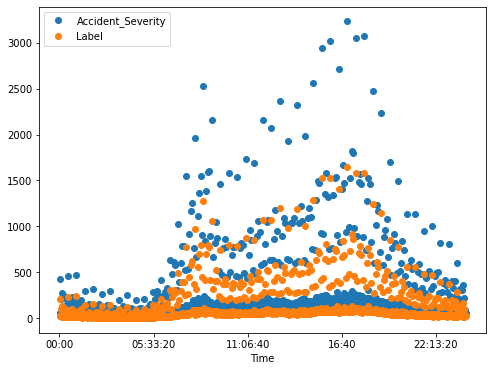

In [11]:
# BY DATE
df_RS["Date"] = pd.to_datetime(df_RS["Date"], format="%d/%m/%Y")
df_date = df_RS.groupby("Date").sum().reset_index()
df_date["Date"] = df_date["Date"].dt.date

# BY TIME
df_RS["Time"] = pd.to_datetime(df_RS["Time"], format="%H:%M")
df_time = df_RS.groupby("Time").sum().reset_index()
df_time["Time"] = df_time["Time"].dt.time

# BY week
df_week = df_RS.groupby("Day_of_Week").sum().reset_index()
#df_week["Day_of_Week"] = df_week['Day_of_Week'].dt.week

# Let's plot it
# There are two peaks in along the day, I guess start and end of the office time. 
# The second one looks higher. There is clearly less amount of accidents during the night.
df_time.set_index("Time")[["Accident_Severity", "Label"]].plot(style='o',figsize=[8,6])

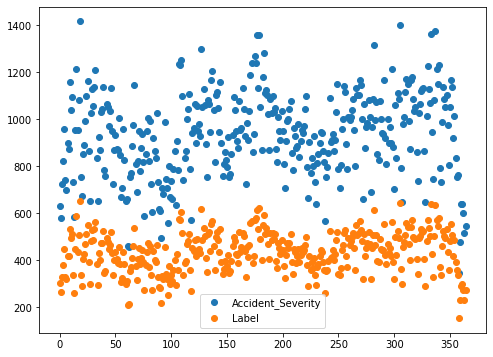

In [12]:
# The sparcity of the data along the year is very high and I am not sure if those peaks are
# outliers or precise dates (I did not check other years)
df_date[["Accident_Severity", "Label"]].plot(style='o',figsize=[8,6])

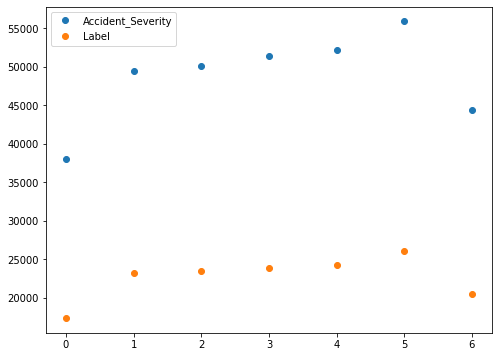

In [13]:
# The day of the week is in a English format so 0=Sunday. 
# We can see that the weekends the number of accdients is smaller but it increase along week until Friday
df_week[["Accident_Severity", "Label"]].plot(style='o',figsize=[8,6])

In [14]:
# I prefer to do not join these columns since they look to provide different information
# Maybe for a not NN I will give more weight to the week and time.
# The NN would update the weights of each variable in the shallow layers

In [15]:
# Before going farther we swithc to numeric format
# Date
df_RS["Date"] = df_RS.apply(lambda x: x["Date"].strftime('%j'),axis=1)
df_RS["Date"] = pd.to_numeric(df_RS["Date"])
# Time
df_RS["Time"] = df_RS["Time"].dt.time
df_RS["Time"] = df_RS["Time"].apply(lambda x: (x.hour)*60 + x.minute)

In [16]:
df_RS.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122567 entries, 2018010080971 to 2018984116418
Data columns (total 27 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   Longitude                                122567 non-null  float64
 1   Latitude                                 122567 non-null  float64
 2   Police_Force                             122567 non-null  int64  
 3   Accident_Severity                        122567 non-null  int64  
 4   Number_of_Vehicles                       122567 non-null  int64  
 5   Number_of_Casualties                     122567 non-null  int64  
 6   Date                                     122567 non-null  int64  
 7   Day_of_Week                              122567 non-null  int64  
 8   Time                                     122567 non-null  int64  
 9   Local_Authority_(District)               122567 non-null  int64  
 10  1st_Road_Class    

In [17]:
####################      LOCALIZATION      ####################

In [18]:
# We group by label to see if there's so much difference
grouped = df_RS.groupby(by=["Label"])
df_1 = grouped.get_group(1)
df_2 = grouped.get_group(2)
df_3 = grouped.get_group(3)

In [19]:
# We can consider the labels with-1 as outliers
df_RS["Label"].value_counts()

 1    87481
 2    34143
 3      941
-1        2
Name: Label, dtype: int64

(49.412362, 61.263721999999994)

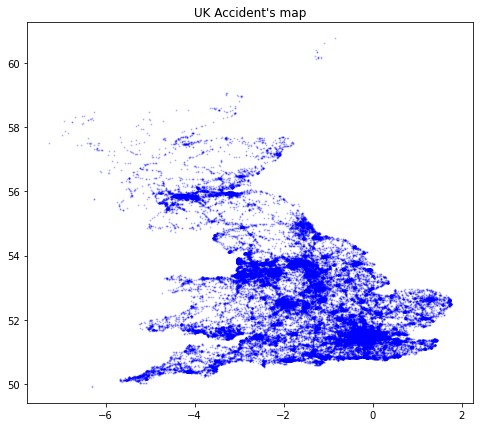

In [20]:
# Probably the number of accidents is higher in London and other big cities
# I do not have the density of the population so I can't guess if the number of accidents 
# per population os bigger in the country
import matplotlib.pyplot as plt
Box = (df_RS.Longitude.min()-0.5, df_RS.Longitude.max()+0.5, df_RS.Latitude.min()-0.5, df_RS.Latitude.max()+0.5)
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df_1.Longitude, df_1.Latitude, zorder=1, alpha= 0.2, c='b', s=1)
ax.set_title("UK Accident's map")
ax.set_xlim(Box[0],Box[1])
ax.set_ylim(Box[2],Box[3])

(49.412362, 61.263721999999994)

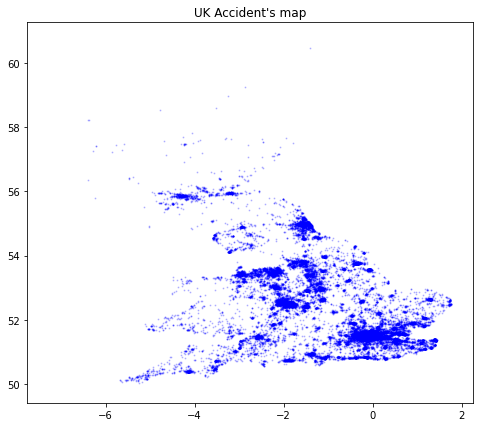

In [21]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df_2.Longitude, df_2.Latitude, zorder=1, alpha= 0.2, c='b', s=1)
ax.set_title("UK Accident's map")
ax.set_xlim(Box[0],Box[1])
ax.set_ylim(Box[2],Box[3])

(49.412362, 61.263721999999994)

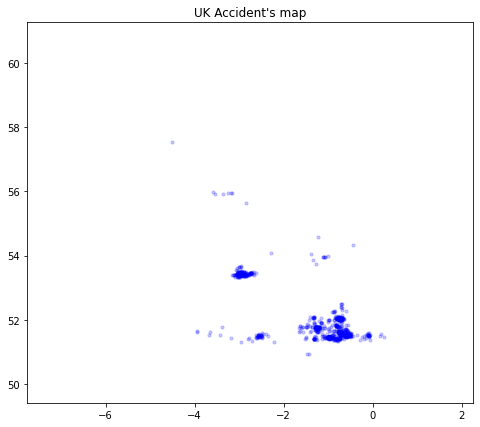

In [22]:
fig, ax = plt.subplots(figsize = (8,7))
ax.scatter(df_3.Longitude, df_3.Latitude, zorder=1, alpha= 0.2, c='b', s=10)
ax.set_title("UK Accident's map")
ax.set_xlim(Box[0],Box[1])
ax.set_ylim(Box[2],Box[3])

In [23]:
# If you look online for the density it fits pretty well the last plots

In [24]:
####################    SPLITING DATA SETS    ####################

In [25]:
# I guess the option is to start preparing the data for the model
# Since it is a classification problem with an amount of data that my computer can support pretty well
# I am going to use Cross Validation to choose the model among a few from SKL and then see if a Simple NN do it better. 
# We do not need convolutions or recurrent models since it's not sequential and we do not need to share weights among
# the features.

In [26]:
# I am not sure which is the goal of the classification so since Acc is an average weight of Precission and Recall
# it's a good general metric by default. Maybe, I will explain something about the confusion matrix later
# The -1 labels has just two samples among 122k, we consider them outliers
df_RS["Label"].value_counts()

 1    87481
 2    34143
 3      941
-1        2
Name: Label, dtype: int64

#######       Amount of data per label      #######

In [27]:
# Since the amount of samples per label is really different I have tried to use the same amount data per label
# But the resulting neural network still have a hard overfitting
# In fact, I guess it finds its minimum the Loss function where it labels all the predictions equal 
# because changing the size of the data sets per label the Accuracy tends to be the percent of the 
# most common label: 
# 1.   0.5 when I use df_1 and df_2 with same amount of data
# 1.   0.33 when I use df_1, df_3 and df_2 with same amount of data
# 1.   0.7136 when I use df_1, df_3 and df_2 with their original amount of data (Label=1 is 87481/122580= 0.7136)

# cluster_dim = min(df_1.shape[0],df_2.shape[0])
#df_1 = df_1.sample(n=cluster_dim)
#df_2 = df_2.sample(n=cluster_dim)
#df_3 = df_3.sample(n=cluster_dim)

In [28]:
#######     Normalization    #######

In [29]:
from sklearn import preprocessing
MMS = preprocessing.MinMaxScaler()

df_1_cols = df_1.columns.tolist()
df_2_cols = df_2.columns.tolist()
df_3_cols = df_3.columns.tolist()

df_1_rows = df_1.index.tolist()
df_2_rows = df_2.index.tolist()
df_3_rows = df_3.index.tolist()


Values_1 = df_1.values
Values_2 = df_2.values
Values_3 = df_3.values

scaled_1 = MMS.fit_transform(Values_1)
scaled_2 = MMS.fit_transform(Values_2)
scaled_3 = MMS.fit_transform(Values_3)

df_1_1 = pd.DataFrame(data = scaled_1, index = df_1_rows, columns = df_1_cols)
df_1_2 = pd.DataFrame(data = scaled_2, index = df_2_rows, columns = df_2_cols)
df_1_3 = pd.DataFrame(data = scaled_3, index = df_3_rows, columns = df_3_cols)

In [30]:
#######     plitting for normalized and not    #######

In [31]:
# We shuffle the groups before
from sklearn.utils import shuffle
def splitting(df_1,df_2,df_3):
    df_1 = shuffle(df_1)
    df_2 = shuffle(df_2)
    df_3 = shuffle(df_3)
    # Get the train sets
    train_1 = df_1.sample(frac = 0.8, axis=0)
    train_2 = df_2.sample(frac = 0.8, axis=0)
    train_3 = df_3.sample(frac = 0.8, axis=0)
    # getting their indexes and creating filters
    list_1_train = train_1.index.tolist()
    list_2_train = train_2.index.tolist()
    list_3_train = train_3.index.tolist()
    #
    filter_1 = df_1.index.isin(list_1_train)
    filter_2 = df_2.index.isin(list_2_train)
    filter_3 = df_3.index.isin(list_3_train)
    # take as test the complementaries
    test_1 = df_1.loc[~filter_1]
    test_2 = df_2.loc[~filter_2]
    test_3 = df_3.loc[~filter_3]
    # We join again the data sets and shuffle to don't send the batches by label
    train = shuffle(train_1.append(train_2, ignore_index = True).append(train_3, ignore_index = True))
    test = shuffle(test_1.append(test_2, ignore_index = True).append(test_3, ignore_index = True))
    #train = shuffle(train_1.append(train_2, ignore_index = True))
    #test = shuffle(test_1.append(test_2, ignore_index = True))
    # Split into X and Y
    X_train = train[train.columns.tolist()[0:-1]]
    X_train_2 = train[train.columns.tolist()[2:-1]]
    Y_train = train["Label"]
    X_test = test[test.columns.tolist()[0:-1]]
    X_test_2 = test[test.columns.tolist()[2:-1]]
    Y_test = test["Label"]
    return X_train, Y_train, X_test, Y_test, X_train_2, X_test_2

In [32]:
X_train, Y_train, X_test, Y_test, X_train_2, X_test_2 = splitting(df_1,df_2,df_3)
X_train_norm, Y_train_norm, X_test_norm, Y_test_norm, X_train_2_norm, X_test_2_norm = splitting(df_1_1,df_1_2,df_1_3)

In [35]:
####################    MODELS   ####################

In [46]:
# I few SKL tools
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
NB = MultinomialNB()
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
from sklearn import svm

In [37]:
# MultinomialNB is discarted by the negative values in the not normalized dataset

In [40]:
NB.fit(X = X_train_norm,y = Y_train_norm)
NB_pred = NB.predict(X_test_norm)
metrics.accuracy_score(Y_test_norm,NB_pred)

1.0

In [41]:
metrics.confusion_matrix(Y_test,NB_pred)

array([[    0,     0,     0,     0],
       [17496,     0,     0,     0],
       [ 6829,     0,     0,     0],
       [  188,     0,     0,     0]])

In [42]:
# Randomforest are a good option. We do not understand completely all the features behaviors
# and it does not need so much data mining

In [43]:
# Random forest: Not normalized, with 26 feautures
RF = RandomForestClassifier(max_depth=20,max_features=0.5)
RF.fit(X = X_train,y = Y_train)
RF_pred = RF.predict(X_test)
metrics.accuracy_score(Y_test, RF_pred)

0.7994533512829927

In [44]:
# Random forest: Normalized, with 26 feautures
RF = RandomForestClassifier(max_depth=20,max_features=0.5)
RF.fit(X = X_train_norm,y = Y_train_norm)
RF_pred = RF.predict(X_test_norm)
metrics.accuracy_score(Y_test_norm, RF_pred)

1.0

In [45]:
# Random forest: Not normalized, with 24 feautures (avoid those which are float)
RF = RandomForestClassifier(max_depth=20,max_features=0.5)
RF.fit(X = X_train_2,y = Y_train)
RF_pred = RF.predict(X_test_2)
metrics.accuracy_score(Y_test, RF_pred)

0.7996165300044874

In [46]:
# Random forest: Not normalized, with 24 feautures (avoid those which were float, now all of them are)
RF = RandomForestClassifier(max_depth=20,max_features=0.5)
RF.fit(X = X_train_2_norm,y = Y_train_norm)
RF_pred = RF.predict(X_test_2_norm)
metrics.accuracy_score(Y_test_norm, RF_pred)

1.0

In [47]:
# The library comes with some pruning algorithm in the back if I remember correctly but it looks like the overfitting
# The splitting function shuffles the data but it still get this acc.
from sklearn.tree import export_graphviz
estimator = RF.estimators_[5]
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = X_train_2_norm.columns.tolist(),
                class_names = ["1","2","3"],
                rounded = True, proportion = False, 
                precision = 2, filled = True)
# Convert to png by commands
#from subprocess import call
#call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])
# Display
#from IPython.display import Image
#Image(filename = 'tree.png')

In [33]:
##############     S.V.M.     ##############

By default it's rbf
The complexity of this algorithm is O(n_samples^2 * n_features)
After waiting for two hours with all the features it did not stop. So, I am going to reduce at leats the number of features since some of them look rendundat. I have picked up 6 that I guess can give an impression of the localization and the type of accident, which I found the most relevants.
We could also use linear kernels, not RBF, which are much more faster. But the SVM optimize the boundary and it is pretty obvious that even with those five features the boundary might have very non linear shape.

In [43]:
X_train_sm = X_train_norm[["Longitude","Latitude","Number_of_Casualties","Weather_Conditions","Special_Conditions_at_Site","Urban_or_Rural_Area"]]
X_test_sm = X_test_norm[["Longitude","Latitude","Number_of_Casualties","Weather_Conditions","Special_Conditions_at_Site","Urban_or_Rural_Area"]]

In [44]:
X.shape

(98052, 6)

In [47]:
# SVM with radial kernel for 6 of the features normalized
classf = svm.SVC()
classf.fit(X_train_sm,y = Y_train)
classf_pred = classf.predict(X_test_sm)
metrics.accuracy_score(Y_test, classf_pred)

0.7137437278178925

In [48]:
##############################################################
####################    NEURAL NETWORKS   ####################

In [49]:
# Libraries for DL
import tensorflow as tf
from tensorflow import keras
import keras
from keras import backend as K # For the F1 score
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Reshape, Dropout #, Input

##############  METRICS: Recall, Precision, F1 Score ##############

In [50]:
# This cell has been copied from my old code
def recall_m(Y_true, Y_pred):
    true_positives = K.sum(K.round(K.clip(Y_true * Y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(Y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(Y_true, Y_pred):
    true_positives = K.sum(K.round(K.clip(Y_true * Y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(Y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(Y_true, Y_pred):
    precision = precision_m(Y_true, Y_pred)
    recall = recall_m(Y_true, Y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#################### Changing the input columns ####################

In [51]:
# Split into X and Y
#X_train = train[train.columns.tolist()[0:2]]
#Y_train = train["Label"]
#X_test = test[test.columns.tolist()[0:2]]
#Y_test = test["Label"]

###################### Using Dataset objects ######################

In [52]:
# Move to Np and then Dataset objects
#X_train_np = np.array(X_train.values)
#Y_train_np = np.array(Y_train.values)
#X_test_np = np.array(X_test.values)
#Y_test_np = np.array(Y_test.values)
#training_data = tf.data.Dataset.from_tensor_slices((X_train_np,Y_train_np))
#test_data = tf.data.Dataset.from_tensor_slices((X_test_np,Y_test_np))
# We prepare the batches
#training_data = training_data.batch(20)
#test_data = test_data.batch(10)

##########################   Classic NN   ##########################

In [54]:
#model = tf.keras.Sequential()
#model.add(tf.keras.layers.Reshape((26,)))
#model.add(tf.keras.layers.Embedding(embeddings.shape[0], embeddings.shape[1], input_length=max_length, trainable=False, weights=[embeddings], mask_zero=True))
#model.add(tf.keras.layers.Dense(100, input_shape=(26,), activation='tanh'))

#model.add(tf.keras.layers.Dense(50,activation='elu'))
#model.add(tf.keras.layers.Dropout(0.5))

#model.add(tf.keras.l.add(tf.keras.layers.Input(shape=(26,)))ayers.Conv1D(filters=200,kernel_size=3,padding='valid'))
#model.add(tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,beta_initializer='zeros',
#                              gamma_initializer='ones',moving_mean_initializer='zeros', moving_variance_initializer='ones'))

#model.add(tf.keras.layers.Dense(100, activation='elu'))
#model.add(tf.keras.layers.Dropout(0.5))

#model.add(tf.keras.layers.Dense(500, activation='elu'))
#model.add(tf.keras.layers.Dense(200, activation='elu'))
#model.add(tf.keras.layers.Dense(50, activation='elu'))
#model.add(tf.keras.layers.Dropout(0.5))
#model.add(tf.keras.layers.Dense(25, activation='elu'))
#model.add(tf.keras.layers.Dropout(0.5))

#model.add(tf.keras.layers.Dense(1, activation='softmax'))

model = Sequential()
model.add(Reshape((26,)))
#model.add(Input( shape=(26,), batch_size=100, name="Input_layer"))
#model.add(Dense(100))
#model.add(Activation("elu"))
#model.add(Dropout(0.5))
model.add(Dense(70))
model.add(Activation("elu"))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation("elu"))
model.add(Dropout(0.5))
model.add(Dense(70))
model.add(Activation("elu"))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation("softmax"))

#################### Shaering features approach ####################

In [55]:
model_rnn = tf.keras.Sequential()
model_rnn.add(tf.keras.layers.Embedding(X_train.shape[0], X_train.shape[1], input_length=26,
                                    trainable=False, weights=[X_train], mask_zero=True))
model_rnn.add(tf.keras.layers.SpatialDropout1D(0.25))
model_rnn.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, dropout=0.3, recurrent_dropout=0.3)))
model_rnn.add(tf.keras.layers.Dropout(0.2))
model_rnn.add(tf.keras.layers.Dense(50, activation='elu'))
model_rnn.add(tf.keras.layers.Dense(25, activation='elu'))
model_rnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [56]:
# In the original model they use a different loss function. We take the most common for a binary classification
# adams (mix of momentum and RMSProp) for the optimizer.
# Since we do not know the goal of the classifier we are going to calculate the 4 most common measures
my_optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.2,
    beta_1=0.7,
    beta_2=0.7,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)
model.compile(loss='categorical_crossentropy', optimizer=my_optimizer,
               metrics=['acc',f1_m, precision_m, recall_m])
#model_rnn.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['acc',f1_m, precision_m, recall_m])

In [57]:
# Model's check point
import datetime
import os
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
name = 'Sentiment_classifier_res_net_-' + timestr

checkpoint_path = os.path.join(base_path, "checkpoints", "+name+", "cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)
os.system('mkdir {}'.format(checkpoint_dir))

# save model after each epoch
cp_callback = ModelCheckpoint(filepath = checkpoint_path, verbose=1)

tensorboard_callback = TensorBoard(log_dir = 'tensorboard_logs/'+name, histogram_freq=1)

################    Training and plotting     ################

In [58]:
# Training and plotting
history = model.fit(X_train, Y_train,epochs=10, verbose=1, 
                    validation_data=(X_test, Y_test),
                    batch_size=200,callbacks=[cp_callback, tensorboard_callback])

Epoch 1/10

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

  1/491 [..............................] - ETA: 0s - loss: 0.0000e+00 - acc: 0.7100 - f1_m: 1.0000 - precision_m: 1.0000 - recall_m: 1.0000WARNING:tensorflow:From /home/alejo/.local/lib/python3.8/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
480/491 [============================>.] - ETA: 0s - loss: 0.0000e+00 - 

dict_keys(['loss', 'acc', 'f1_m', 'precision_m', 'recall_m', 'val_loss', 'val_acc', 'val_f1_m', 'val_precision_m', 'val_recall_m'])


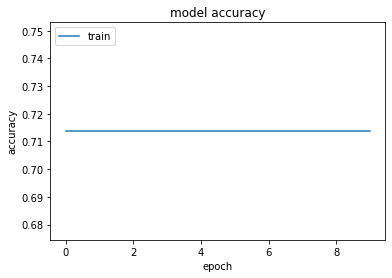

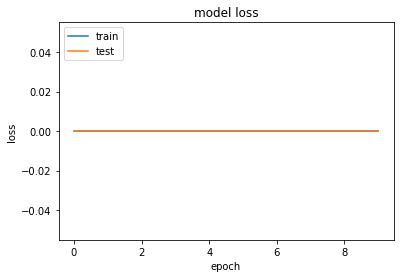

In [59]:
# We summarize the history for accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
#plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# We summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [60]:
# Model's summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 26)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 70)                1890      
_________________________________________________________________
activation_5 (Activation)    (None, 70)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 70)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                710       
_________________________________________________________________
activation_6 (Activation)    (None, 10)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 10)               

I guess the Loss function converges to a minimum where it labels all the predictions equally, 
because changing the size of the data sets per label makes Accuracy tend to be the percent of the 
most common label: 
 1.   0.5 when I use df_1 and df_2 with same amount of data
 2.   0.33 when I use df_1, df_3 and df_2 with same amount of data
 3.   0.7136 when I use df_1, df_3 and df_2 with their original amount of data (Label=1 is 87481/122580= 0.7136)
We have a problem of overfitting:
 1. I tried to reduce the depth but still produce overfitting (original it was 150k parameters)
 2. I tried to add hard dropouts after the layers the depth but still overfitting
 3. The regularization is given by ADAMS; incressing regularization did not work neither
 4. I tried others approaches: shaering features (conv1, or LSTM, autoencoder architecture to see common features     in the bottle neck,to capture the redundance of the three main types of accidents), Cross_validation with         different dataset size. I could try with Resnet, but it's not so deep, and I have passed the time.

###   Model performance
To me it's pretty clear that the original approach with "classic" classifiers is a better option, 
cheaper and with higher accuracy. I would implement this problem with random forest, I guess it's the faster and with highest accuary which also work for different kinds of data.
 1. NB: it needs normalization I am not sure if there's an overfitting in our case
 2. RF: The best option
 3. SVM: Too expensive and tends to converge to the same minimum that the NN
 4. NN: described just above

###   Toolkit (algorithms)
 0. Loading data: os module. It writes the paths depending of the OS, so the code should work for OX, ubuntu and       Windows
 1. Data mining: mainly pandas. At some point numpy or sklearn to shuffle
 2. Plotting: Matplotlib
 3. No NN models: Naive Bayes, Random Forest and SVM from sklearn, without so much tuning of the parameters
 4. NN models: Tensorflow and keras.

###   Insights you gained from the data
This was said along the notebook, but a few remarks are:
 1. There are three types features based on localization, type of accident and datetime
 2. There are some periodicities along the time, mainly week and hour of the day
 3. The localization is mainly given with Longitud and Latitude (and this two matters while considering a model)
 4. I spend a while trying to fit the net and I have passed the 5 hours now, but if would spend more time I would     like to look deeper into the data. For example, I would do the map plots again but with "Number_of_Casualties"     and each one of the labels.
 5. The amount of data is not enough to use NN.

###  Limitations of the data and your approach – what would you do differently if you had more time or resources?
I have done comments about it before. But right now I would do the following
 1. Try to print the results of those that geva 1 in accuaricy. It looks to good and I want to be sure what's         going on behind. I let a try that I was doing to print the random forest decission tree.
 2. If they are not working properly try to solve it. 
 3. With more computational capacity and allowed to use the other years I would take them to add data. Maybe the       NN fits better
 4. If the acc gets down because there was a mistake and I would have more computational capacity I would try to         train the SVM with more variables and data and check the results with different variables and data to             undertand its result and the one from the NN maybe.
 5. Maybe with more time I would thing about a mix model, like adding PCA before or some way of trait the data         before  the model